## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines boring_patch, trained on a patch where the behavior of both the amplitude and the phase was relatively smooth and predictable.

Let's load the python modules and the model, first.

In [1]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'boring_patch'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB

[0.01, 5, 2048, 0.0001, 50000, 1.5, 0.5, 0.1, 0.1]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

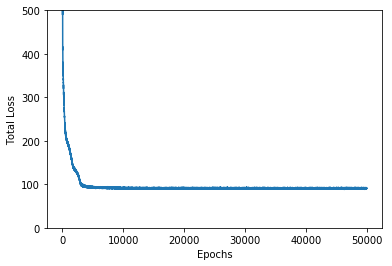

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 500])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

It appears that the overall loss has plateaued around

In [3]:
print(L[-1])

91.52853393554688


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


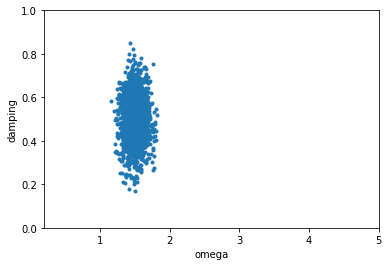

In [38]:
data, groundTruth = datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("omega")
plt.ylabel("damping")
plt.ylim([0, 1])
plt.xlim([0.2, 5.0])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [5]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [6]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[ 0.0122398  -0.08423379]
 [ 0.08989816 -0.04343654]
 [ 0.01195963  0.07488099]
 ...
 [-0.06818844  0.00519341]
 [-0.02527225 -0.02838544]
 [ 0.04993227  0.01056932]]


In [7]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.03887270955292408
Typical Amp Error
0.05035008663875557
Typical phase error / phase range
0.034184416812624886
Typical amp error / amp range
0.06411065522918304


So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $), as well as a distribution of the errors.

In [3]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


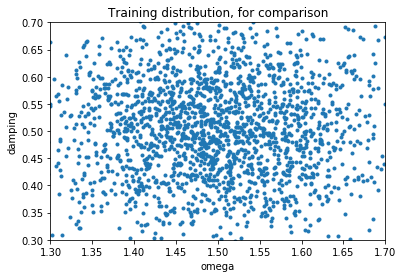

In [39]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [5]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [6]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

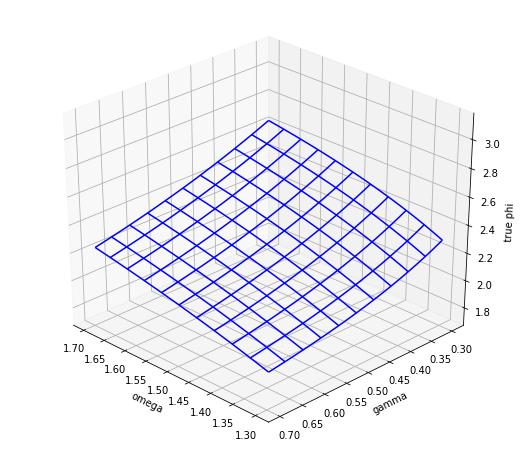

In [21]:
# Plot Phi, true 

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
#surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")

ax.set_zlim(1.7, 3.15)


fig

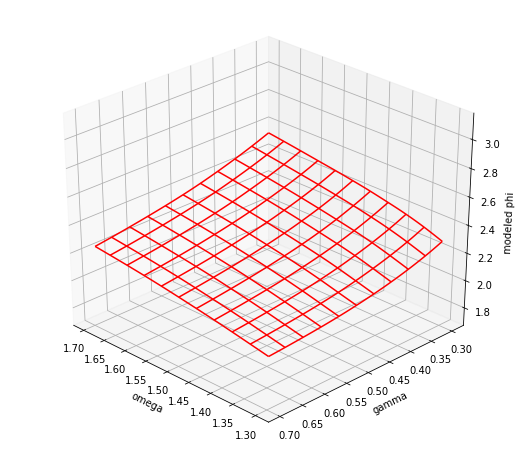

In [22]:
# Plot Phi, modeled 

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("modeled phi")
ax.set_zlim(1.7, 3.15)

fig

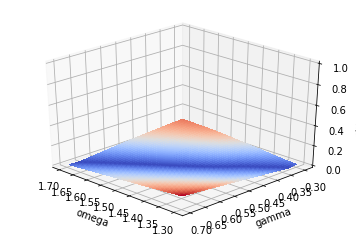

In [20]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

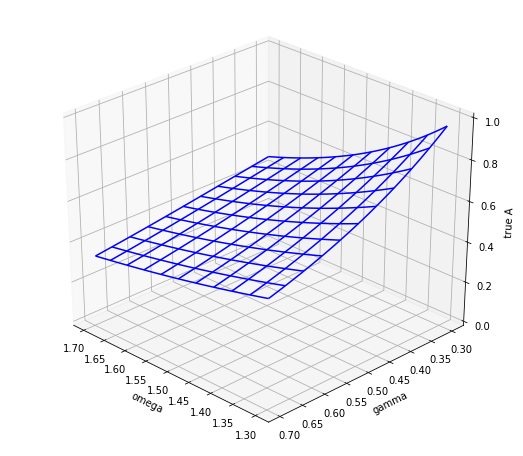

In [23]:
# Plot A

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
#surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim(0, 1)

fig

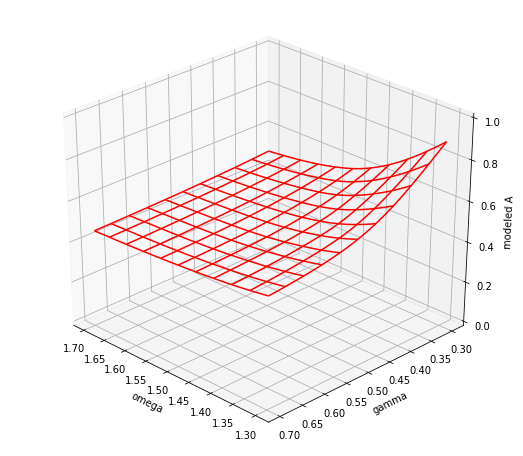

In [24]:
fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("modeled A")
ax.set_zlim(0, 1)

fig

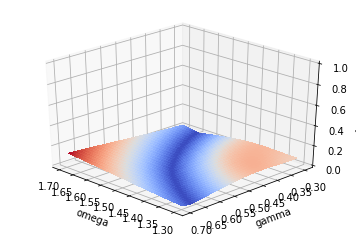

In [23]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

In [25]:
# Make the data

wmin = 0.2
wmax = 5.0
wstep = (wmax - wmin)/100

bmin = 0.01
bmax = 1.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)
print(W.shape)

(101, 100)


In [26]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


NameError: name 'data' is not defined

In [27]:
# Compute the ground truth

Phi = phi(W, B)
A = amplitude(W, B)

In [28]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10100, 1), B.reshape(10100, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(101, 100)
modelA = npo[:, 1].reshape(101, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


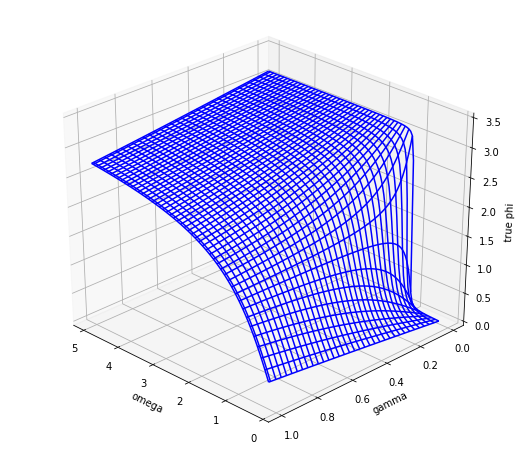

In [32]:
# Plot Phi, true and modeled

fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
#surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")
ax.set_zlim(0, 3.5)

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


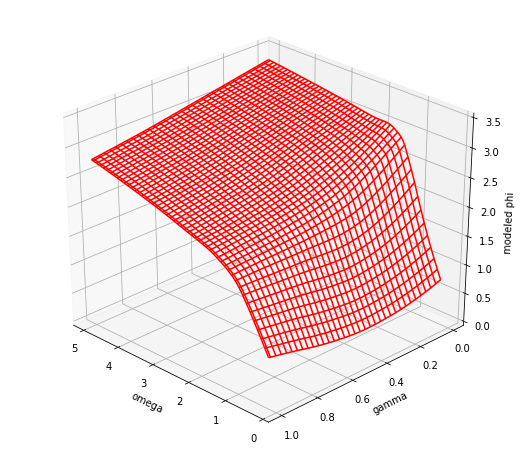

In [31]:
fig = plt.figure(figsize=(9, 8))
ax = fig.gca(projection='3d')

#surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("modeled phi")
ax.set_zlim(0, 3.5)

fig

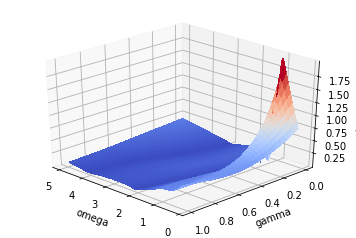

In [29]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

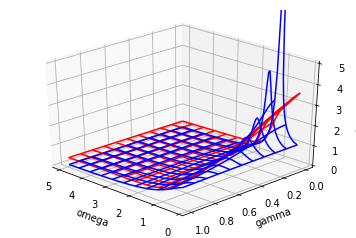

In [33]:
# Plot A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
ax.set_zlim([0, 5])

fig

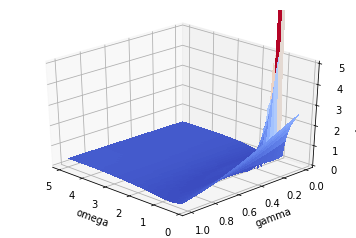

In [34]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [45]:
print("Max predicted phase")
print(max(modelPhi.reshape((10100,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10100,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10100,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10100,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10100,))))
print("Min true phase")
print(min(Phi.reshape((10100,))))
print("Max true amplitude")
print(max(A.reshape((10100,))))
print("Min true amplitude")
print(min(A.reshape((10100,))))

Max predicted phase
3.3338456
Min predicted phase
0.5027236
Max predicted amplitude
3.5973938
Min predicted amplitude
0.35750327



Max true phase
3.1373822065713624
Min true phase
0.004166642554263516
Max true amplitude
26.230985251581906
Min true amplitude
0.03918141559633489


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


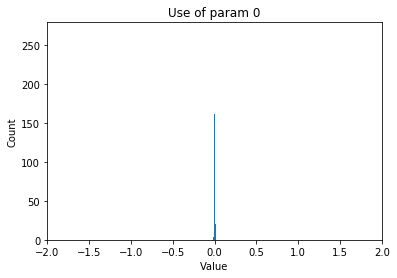

In [49]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


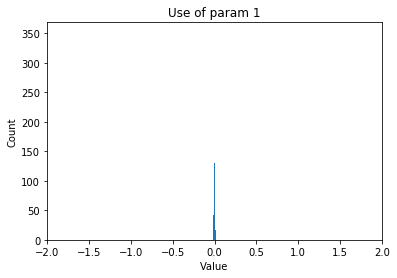

In [50]:
# Param 1 

fig = plt.figure()
plt.hist(means[:, 1], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


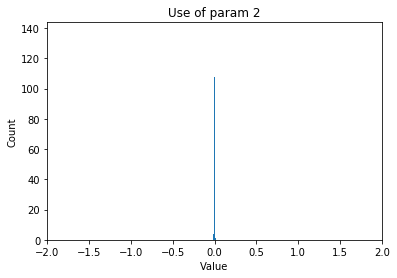

In [51]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


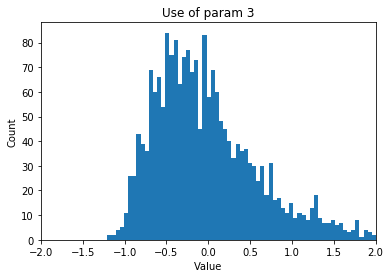

In [52]:
# Param 3

fig = plt.figure()
plt.hist(means[:, 3], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


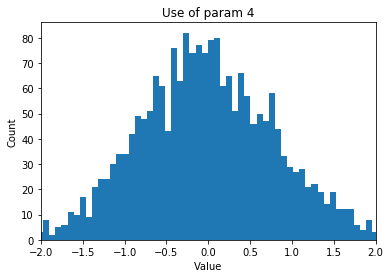

In [53]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, only parameters $3$ and $4$ are used.

Let's plot their dependence on $\omega$ and $\gamma$ within the training distribution.

In [54]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [64]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param3 = npm[:, 3].reshape(100, 100)
param4 = npm[:, 4].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


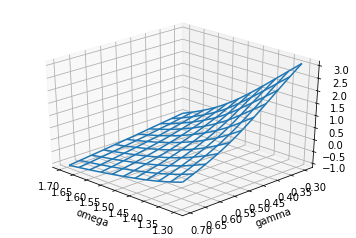

In [57]:
# Plot param 3

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param3, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


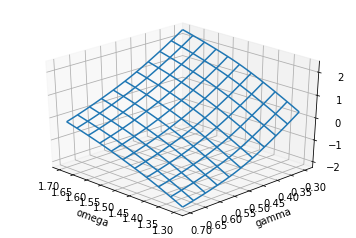

In [58]:
# Plot param 4

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param4, rstride=10, cstride=10)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param3")

fig

In [59]:
# Compute ground truth

Phi = phi(W, B)
A = amplitude(W, B)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


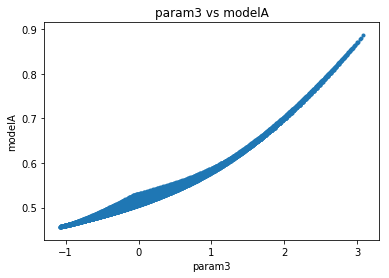

In [65]:
# Compare modelA and param3

fig = plt.figure()
plt.scatter(param3, modelA, marker='.')
plt.title("param3 vs modelA")
plt.xlabel("param3")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


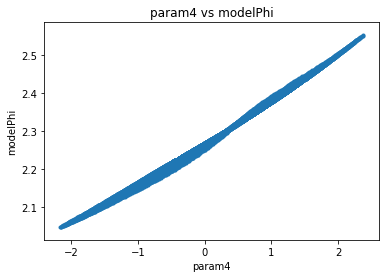

In [66]:
# Compare modelPhi and param4

fig = plt.figure()
plt.scatter(param4, modelPhi, marker='.')
plt.title("param4 vs modelPhi")
plt.xlabel("param4")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

This network performed approximately as expected. It captured the dynamics of the boring patch it was trained on fairly well, with only small discrepancies near poorly-covered corners. Since the true system has two degrees of freedom, only $2$ of the available $5$ latent dimensions were used (though it will be interesting to see whether more degrees of freedom are recruited when dynamics are more complex). Finally, the extrapolation was "logical," growing / shrinking in the same directions as on the patch where the system was trained, but did not capture any nuances of the function - no amplitude peak, no "limit to $0$" amplitude behavior, no "sigmoid" seen in the behavior of the phase.

But perhaps, this is not a strike agains SciNet, but the very unrepresentative patch that we chose; perhaps networks trained on more interesting portions of the space will extrapolate better. We shall see.